In [1]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
import platform

%load_ext autoreload
%autoreload 2

In [2]:
from kalman_steps import *
from helpers import *

In [3]:
TIME_INTERVAL_TO_USE = "1s"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# Convert the time interval string to a pandas Timedelta object
time_interval = pd.Timedelta(TIME_INTERVAL_TO_USE)
# Extract the total seconds from the Timedelta object and convert to float
time_interval_in_seconds = time_interval.total_seconds()
print(f"Time interval in seconds: {time_interval_in_seconds}")

Time interval in seconds: 1.0


In [4]:
file_identifiers = load_identifiers();
pick_ident = "kyzikos_run"
file_name = file_identifiers[pick_ident]["file_name"]
file_ident = file_identifiers[pick_ident]
additional_run_info = {}

Identifiers:
0: basak run 02 (run of basak at 31st.))
1: basak run 01 (run of basak at 30th.))
2: my run 01 (my run on the xth of y at xx:yy))
3: my run 02 (my run on the xth of y at xx:yy))
4: kyzikos_run (kyzikos_2023_30K))


In [5]:
gpx_obj, segment = step_01_load_data(file_name)

/home/dg/GitHubUbuntU/gps_data_with_python/gpx/kyzikos_2023_30K.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/activity_11238879870.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/activity_11238893125_basak02.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/activity_11231936537_basak01.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro_cleaned.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/activity_11212422262.gpx
/home/dg/GitHubUbuntU/gps_data_with_python/gpx/hh_marathon.gpx
Loading file: /home/dg/GitHubUbuntU/gps_data_with_python/gpx/kyzikos_2023_30K.gpx
num of tracks=1


In [6]:
print_known_info(file_ident, ["total_elevation"])
segment.get_uphill_downhill()

unknown total_elevation


UphillDownhill(uphill=0.0, downhill=0.0)

In [7]:
coords = pd.DataFrame([{'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'time': p.time} for p in segment.points])
coords.set_index('time', drop=True, inplace=True)
coords.head()

,lat,lon,ele
time,,,
None,40.396427,27.790300,0.0
None,40.396520,27.789635,0.0
None,40.396566,27.789225,0.0
None,40.396617,27.788834,0.0
None,40.396659,27.788506,0.0


In [8]:
for point in segment.points:
    point.elevation = None

In [9]:
import srtm
elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx_obj, smooth=True)

In [10]:
coords['new_ele'] = [p.elevation for p in gpx_obj.tracks[0].segments[0].points]

In [11]:
segment.get_uphill_downhill()

UphillDownhill(uphill=1023.0945425624864, downhill=1023.0945425624876)

In [12]:
coords.head()

,lat,lon,ele,new_ele
time,,,,
None,40.396427,27.790300,0.0,9.000000
None,40.396520,27.789635,0.0,7.333946
None,40.396566,27.789225,0.0,6.518383
None,40.396617,27.788834,0.0,4.403510
None,40.396659,27.788506,0.0,3.749080


In [13]:
_, distance_vincenty = calc_speed_distance_vincent(segment, verbose=False)
print(f"in {len(distance_vincenty)} points max distance between 2 points is {np.max(distance_vincenty):4.2f} whereas min is {np.min(distance_vincenty[distance_vincenty>0]):4.2f}")

in 2080 points max distance between 2 points is 132.93 whereas min is 0.35


In [14]:
total_elevation_change = sum(abs(coords['new_ele'][1:]-coords['new_ele'][0:-1]))/2
print(f"total_elevation_change={total_elevation_change:4.2f} meters")

total_elevation_change=1181.41 meters


In [15]:
elev_acquired=coords['new_ele'][1:]-coords['new_ele'][0:-1]
elev_acquired = elev_acquired.reset_index(drop=True)
elev_values = elev_acquired.tolist()

dist_acquired = distance_vincenty[1:]
angles = np.arctan2(elev_values, dist_acquired)
dist_acc = np.cumsum(dist_acquired)
elev_acc = np.cumsum(elev_values)

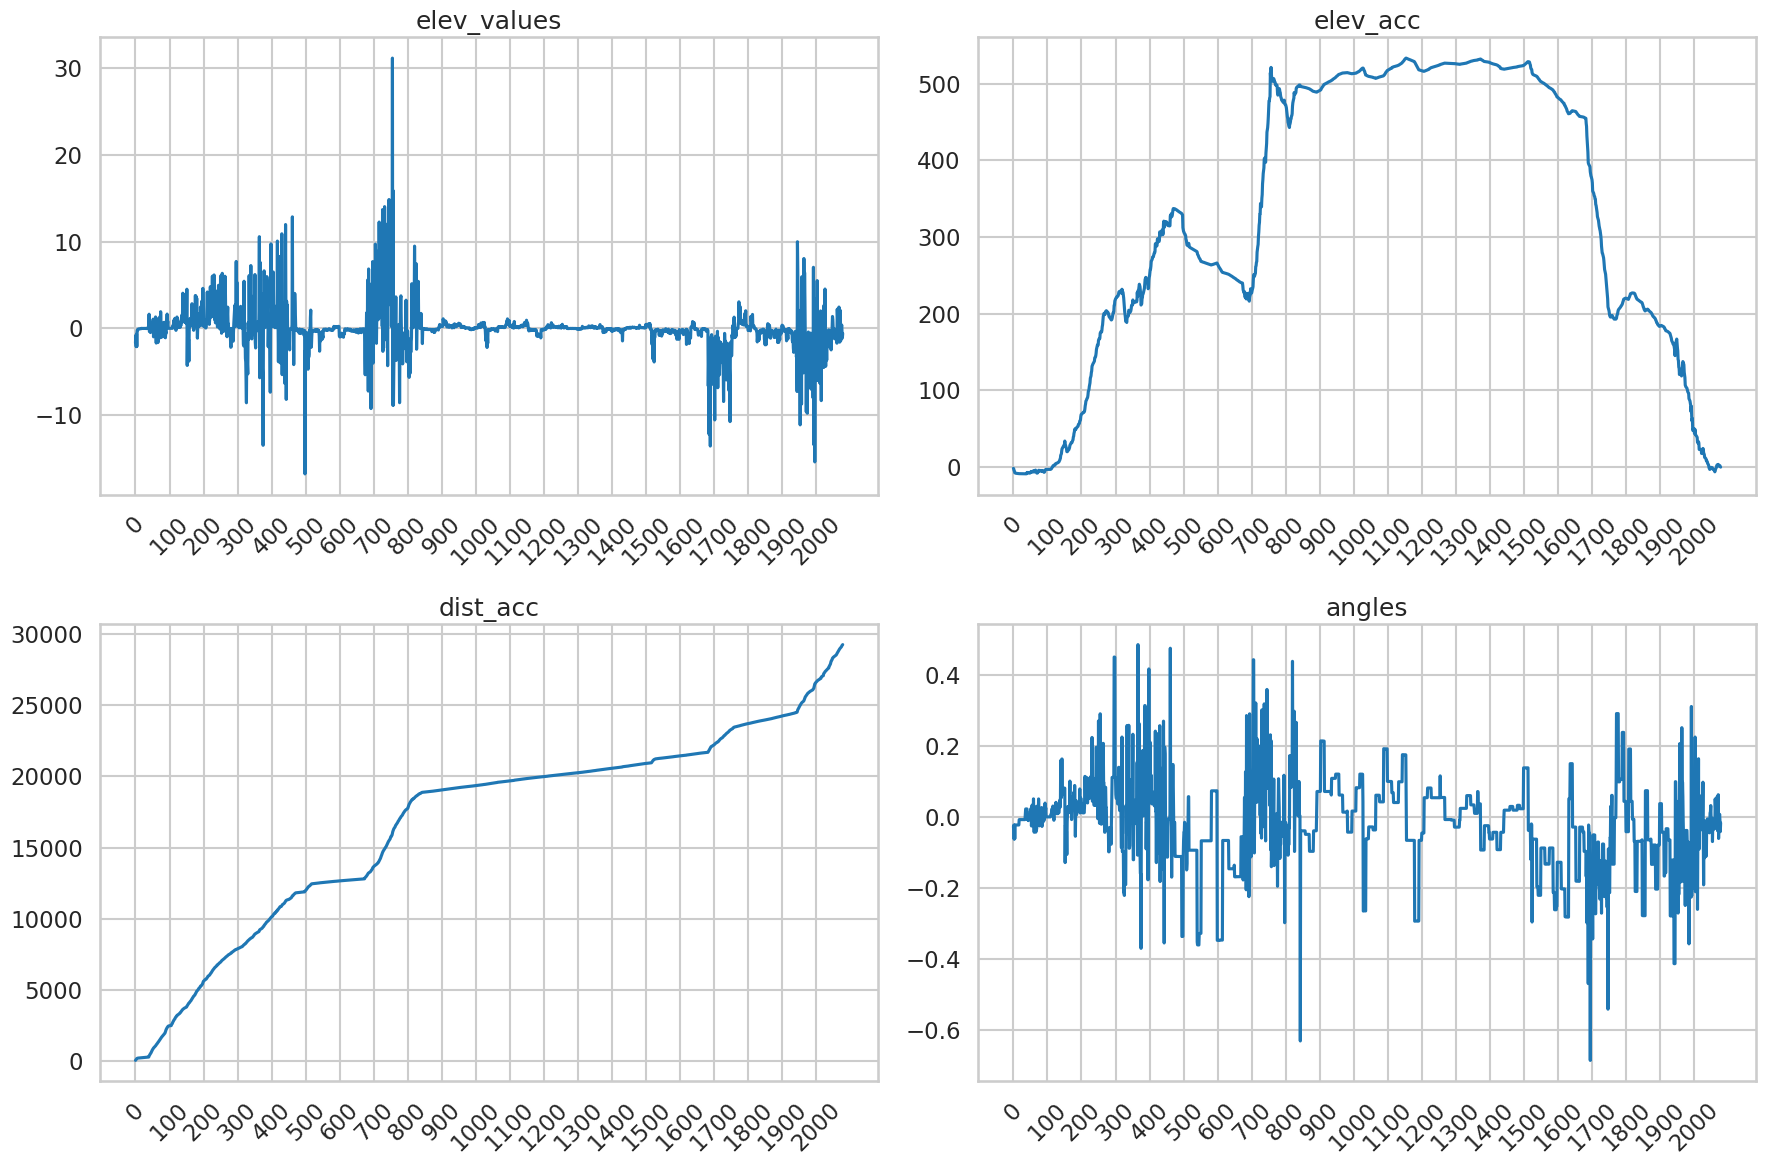

In [19]:
fig, axs = plt.subplots(2,2,figsize=(18,12))
axs[0,0].plot(elev_values)
axs[0,0].set_title("elev_values")
xticks = np.arange(0,len(elev_values),100)
xlabels = [i for i in xticks]
axs[0,1].plot(elev_acc)
axs[0,1].set_title("elev_acc")
axs[1,0].plot(dist_acc)
axs[1,0].set_title("dist_acc")
axs[1,1].plot(angles)
axs[1,1].set_title("angles")
for i in range(2):
    for j in range(2):
        axs[i,j].set_xticks(xticks)
        axs[i,j].set_xticklabels(xlabels, rotation=45)
plt.tight_layout()

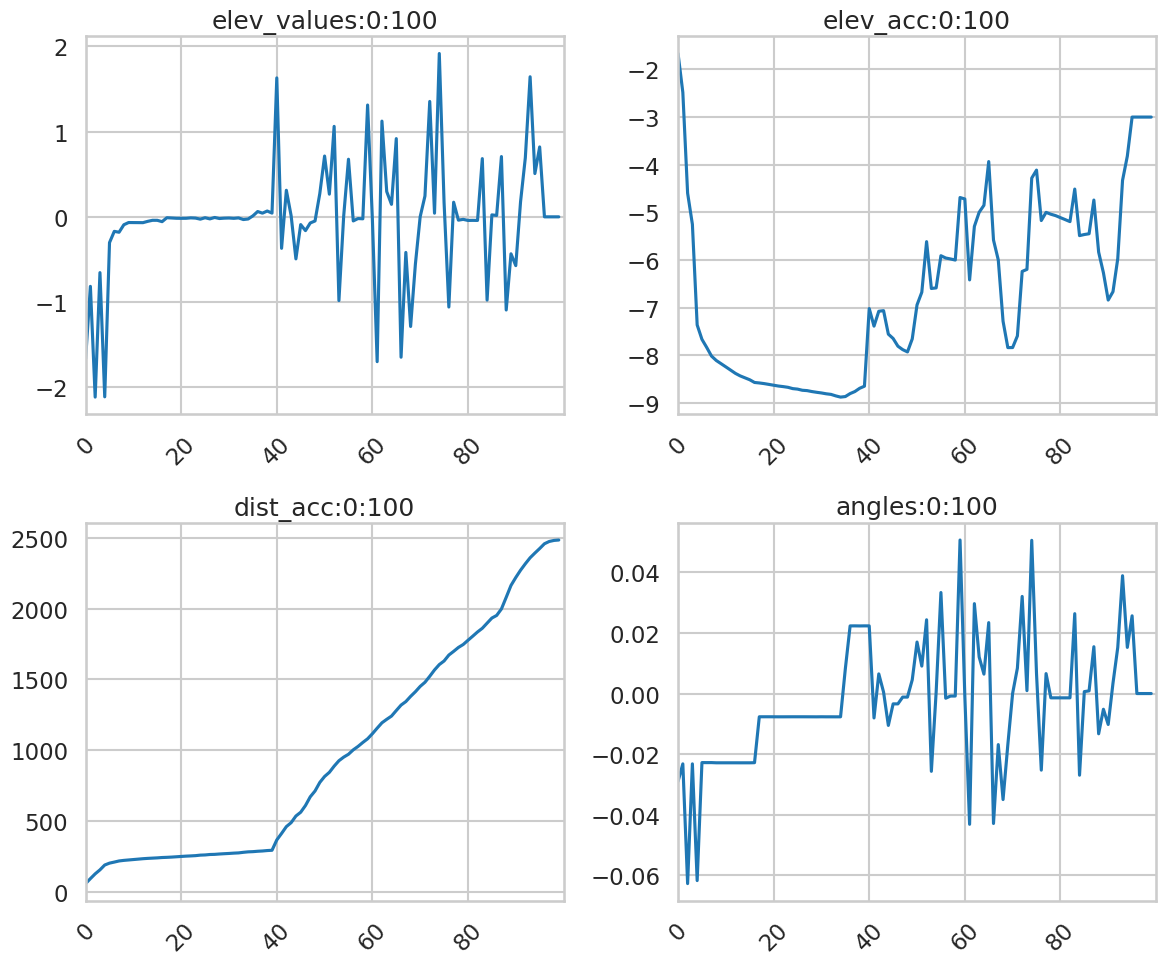

In [25]:
fig, axs = plt.subplots(2,2,figsize=(12,10))
fr=0
to=100
title_add = f"{fr}:{to}"
tick_inc = 20
axs[0,0].plot(elev_values[fr:to])
axs[0,0].set_title(f"elev_values:{title_add}")
xticks = np.arange(0,len(elev_values[fr:to]),tick_inc)
xlabels = [i for i in xticks]
axs[0,1].plot(elev_acc[fr:to])
axs[0,1].set_title(f"elev_acc:{title_add}")
axs[1,0].plot(dist_acc[fr:to])
axs[1,0].set_title(f"dist_acc:{title_add}")
axs[1,1].plot(angles[fr:to])
axs[1,1].set_title(f"angles:{title_add}")
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlim(fr,to)
        axs[i,j].set_xticks(xticks)
        axs[i,j].set_xticklabels(xlabels, rotation=45)
plt.tight_layout()
#plt.plot()

fig = plt.figure(figsize=(10,6))
plt.plot(elev_acc[0:500])
x = [20, 62, 151, 264, 275, 305, 327, 446, 461]
plt.scatter(x,np.zeros(len(x)))

fig, axs = plt.subplots(4)
pick_until = 500
axs[0].plot(angles[0:pick_until])
block_sizes = [5, 10, 20]
added_angles_0 = np.convolve(angles[0:pick_until],np.ones(block_sizes[0],dtype=int),'valid')
axs[1].plot(added_angles_0)
added_angles_1 = np.convolve(angles[0:pick_until],np.ones(block_sizes[1],dtype=int),'valid')
axs[2].plot(added_angles_1)
added_angles_2 = np.convolve(angles[0:pick_until],np.ones(block_sizes[2],dtype=int),'valid')
axs[3].plot(added_angles_2)

tresh=10
changes_row2 = find_direction_change_indices(added_angles_0, tresh=tresh)
axs[1].scatter(np.squeeze(changes_row2), np.zeros(len(changes_row2)))
changes_row3 = find_direction_change_indices(added_angles_1, tresh=tresh)
axs[2].scatter(np.squeeze(changes_row3), np.zeros(len(changes_row3)))
changes_row4 = find_direction_change_indices(added_angles_2, tresh=tresh)
axs[3].scatter(np.squeeze(changes_row4), np.zeros(len(changes_row4)))


plt.tight_layout()


idx::([28]:INC);([58]:dec);([64]:INC);([65]:dec);([66]:INC);([74]:dec);([76]:INC);([78]:dec);([82]:INC);([147]:dec);([156]:INC);([267]:dec);([281]:INC);([311]:dec);([329]:INC);([351]:dec);([353]:INC);([366]:dec);([373]:INC);([386]:dec);([388]:INC);([442]:dec);([443]:INC);([444]:dec);([451]:INC);([467]:dec);()
smoothed:tresh(5)::(28:INC);(58:dec);(65:dec);(77:?);(147:dec);(156:INC);(267:dec);(281:INC);(311:dec);(329:INC);(352:?);(366:dec);(373:INC);(387:?);(443:INC);(451:INC);(467:dec);()
idx::([28]:INC);([58]:dec);([64]:INC);([65]:dec);([66]:INC);([74]:dec);([76]:INC);([78]:dec);([82]:INC);([147]:dec);([156]:INC);([267]:dec);([281]:INC);([311]:dec);([329]:INC);([351]:dec);([353]:INC);([366]:dec);([373]:INC);([386]:dec);([388]:INC);([442]:dec);([443]:INC);([444]:dec);([451]:INC);([467]:dec);()
smoothed:tresh(10)::(28:INC);(70:?);(151:?);(267:dec);(281:INC);(311:dec);(329:INC);(352:?);(369:?);(387:?);(443:INC);(467:dec);()
idx::([28]:INC);([58]:dec);([64]:INC);([65]:dec);([66]:INC);([74]

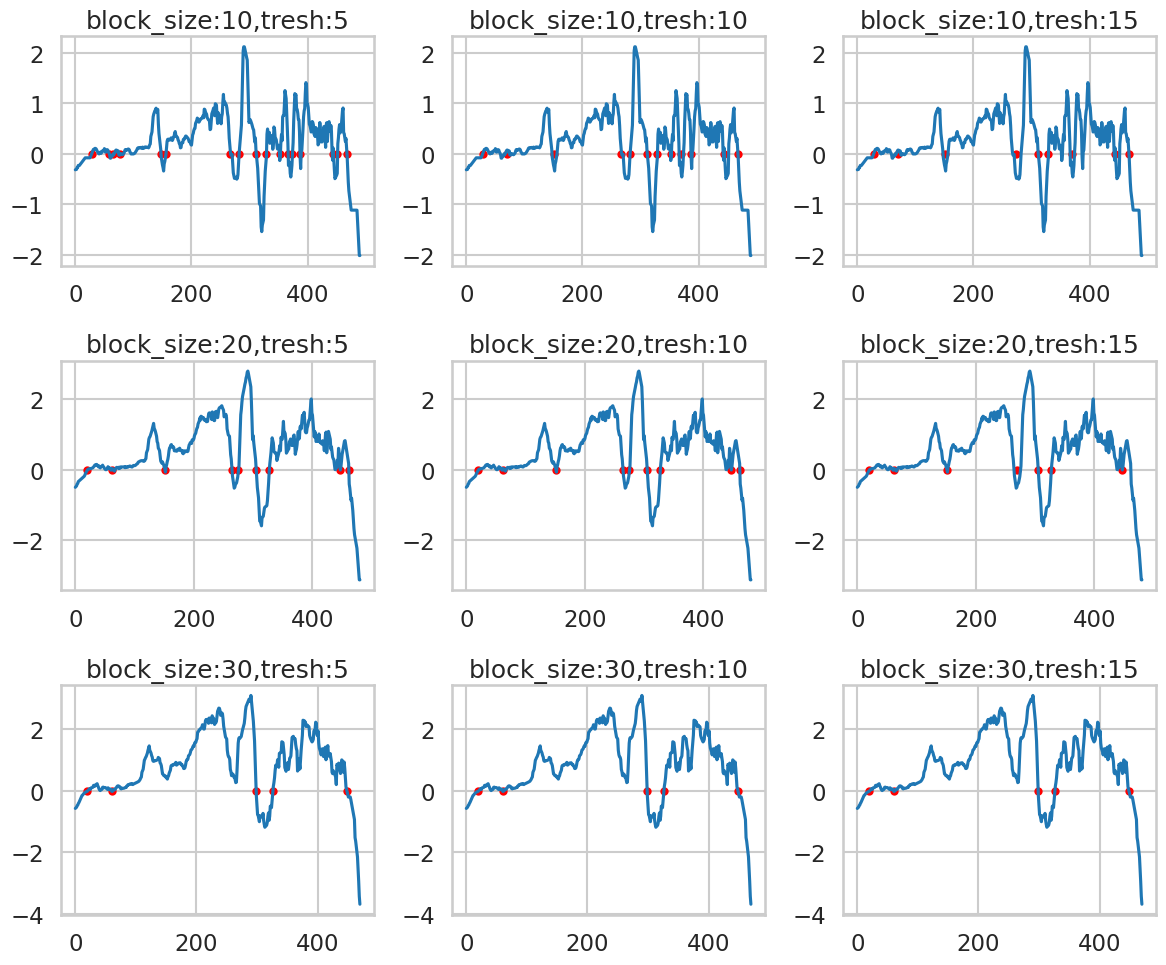

In [35]:
from helpers import find_direction_change_indices
fig, axs = plt.subplots(3,3,figsize=(12,10))
pick_until = 500
change_points = {}
for i in range(3):
    for j in range(3):
        block_size = 10*(i+1)
        tresh = 5*(j+1)
        title_str = f"block_size:{block_size},tresh:{tresh}"
        added_angles = np.convolve(angles[0:pick_until],np.ones(block_size,dtype=int),'valid')
        cpts = find_direction_change_indices(added_angles, tresh=tresh)
        change_points[title_str] = cpts
        axs[i,j].plot(added_angles)
        axs[i,j].scatter(np.squeeze(cpts), np.zeros(len(cpts)), s=20, c='red', marker='o')
        axs[i,j].set_title(title_str)
        #axs[i,j].set_xticks(xticks)
        #axs[i,j].set_xticklabels(xlabels, rotation=45)
plt.tight_layout()

In [ ]:
print(np.column_stack((dist_acquired[0:50], elev_values[0:50],angles[0:50])))

In [93]:
X = angles
print(f"len of X = {len(X)}")
change_idx_X = np.squeeze(np.argwhere(X[1:]*X[:-1]<0))
treshDist = 50 #if a block is less than 25 meters long - discard it
treshElev = 2
modesDetected = []
wasDiscarded = np.zeros(len(change_idx_X))
new_change_idx = [0]
fr = 0
discardThis = False
added_mode = 'NONE'
for idAt in range(0,len(change_idx_X)):
    
    wasDiscardedPrev = idAt>1 and wasDiscarded[idAt-2]
    wasDiscardedCurrent = idAt>0 and wasDiscarded[idAt-1]
    
    i = change_idx_X[idAt]
    to = i-1
    mode = '?' 
    if (X[i]<0 and X[i+1]>0):
        mode = 'dec' 
    if (X[i]>0 and X[i+1]<0):
        mode = 'INC' 
    dist = np.sum(dist_acquired[fr:to])
    elevIncDec = np.sum(elev_values[fr:to])
    elevChange = np.sum(np.abs(elev_values[fr:to]))
    angle_of_block = (180/np.pi)*np.arctan2(elevIncDec, dist)
    discardDueToBlockLength = dist<treshDist
    discardDueToElevChange = elevChange<treshElev
    
    discardDueToPreviousDiscard = wasDiscardedCurrent and not wasDiscardedPrev
    
    if (np.abs(angle_of_block)<1):
        mode = 'FLT' 
    
    modesDetected.append(mode)
    
    discardString = ""
    if discardDueToBlockLength:
        discardString += "BL,"
    if discardDueToElevChange:
        discardString += "EC,"
    if discardDueToPreviousDiscard:
        discardString += "PD,"
        
    # now this block can be either INC dec or FLT
    # it should be needed to be discarded or not
    # first of all consecutive FLT blocks needs to be combined
        
    wasDiscarded[idAt] = discardDueToBlockLength  or discardDueToElevChange
    
    print(f"{discardString:9s}-({i}:fr({fr:3d}):to({to:3d}):m({mode}):dist({dist:8.4f}):aob({angle_of_block:8.4f}),elevChange({elevChange:5.3f}),elevIncDec({elevIncDec:5.3f})")
    if idAt>0:
        #now lets see if we will add i-1 as change point
        mode_was = modesDetected[idAt-1]
        mode_is = mode
        if wasDiscarded[idAt]:
            pass
        elif (mode_was=="FLT") and (mode_is=="FLT"):
            pass
        elif (added_mode==mode_is):
            pass
        elif (mode_was!="FLT") and (mode_is=="FLT"):
            new_change_idx.append(fr)
            added_mode = "FLT"
            print(f"***add {fr} because it changed to FLAT")
        elif not wasDiscarded[idAt]:
            new_change_idx.append(fr)
            added_mode = mode_is
            print(f"***add {fr} because {mode_is} is not discarded")
    fr = i
print("new_change_idx:",new_change_idx)

len of X = 2079
         -(34:fr(  0):to( 33):m(dec):dist(274.2482):aob( -1.8421),elevChange(8.820),elevIncDec(-8.820)
BL,EC,   -(40:fr( 34):to( 39):m(FLT):dist( 12.4795):aob(  0.7339),elevChange(0.211),elevIncDec(0.160)
BL,EC,PD,-(41:fr( 40):to( 40):m(FLT):dist(  0.0000):aob(  0.0000),elevChange(0.000),elevIncDec(0.000)
BL,EC,   -(43:fr( 41):to( 42):m(FLT):dist( 45.8654):aob( -0.4615),elevChange(0.369),elevIncDec(-0.369)
EC,      -(48:fr( 43):to( 47):m(FLT):dist(149.0936):aob( -0.2816),elevChange(0.759),elevIncDec(-0.733)
EC,      -(52:fr( 48):to( 51):m(FLT):dist(143.5812):aob(  0.3745),elevChange(1.035),elevIncDec(0.939)
BL,EC,   -(53:fr( 52):to( 52):m(FLT):dist(  0.0000):aob(  0.0000),elevChange(0.000),elevIncDec(0.000)
BL,EC,   -(55:fr( 53):to( 54):m(INC):dist( 38.2859):aob( -1.4701),elevChange(0.983),elevIncDec(-0.983)
EC,      -(58:fr( 55):to( 57):m(FLT):dist( 51.4145):aob(  0.6997),elevChange(0.724),elevIncDec(0.628)
BL,EC,   -(59:fr( 58):to( 58):m(FLT):dist(  0.0000):aob(  0.00

In [106]:
fr = 0
for idAt in range(1,len(new_change_idx)):  
    i = new_change_idx[idAt]
    to = i-1
    
    dist = np.sum(dist_acquired[fr:to])
    elevIncDec = np.sum(elev_values[fr:to])
    elevChange = np.sum(np.abs(elev_values[fr:to]))
    angle_of_block = (180/np.pi)*np.arctan2(elevIncDec, dist)
    
    mode = 'FLT' 
    if (elevIncDec<-treshElev):
        mode = 'dec' 
    if (elevIncDec>treshElev):
        mode = 'INC'     
    
    str0 = f"dist({dist:8.3f})"
    str1 = f"elevChange({elevChange:6.2f})"
    str2 = f"elevIncDec({elevIncDec:6.2f})"
    print(f"{i:4d}:fr({fr:4d}):to({to:4d}):m({mode}):{str0:12}:aob({angle_of_block:8.4f}),{str1:16},{str2:12}")
    fr = i

  61:fr(   0):to(  60):m(dec):dist(1080.047):aob( -0.2487),elevChange( 17.68),elevIncDec( -4.69)
 119:fr(  61):to( 118):m(INC):dist(1934.117):aob(  0.1979),elevChange( 26.55),elevIncDec(  6.68)
 151:fr( 119):to( 150):m(INC):dist( 702.597):aob(  2.1631),elevChange( 27.01),elevIncDec( 26.54)
 158:fr( 151):to( 157):m(dec):dist( 250.584):aob( -1.2615),elevChange( 14.53),elevIncDec( -5.52)
 273:fr( 158):to( 272):m(INC):dist(3342.622):aob(  3.1301),elevChange(191.80),elevIncDec(182.79)
 288:fr( 273):to( 287):m(dec):dist( 239.219):aob( -2.3505),elevChange( 10.83),elevIncDec( -9.82)
 319:fr( 288):to( 318):m(INC):dist( 427.673):aob(  4.8679),elevChange( 40.65),elevIncDec( 36.42)
 333:fr( 319):to( 332):m(dec):dist( 310.393):aob( -6.6038),elevChange( 48.07),elevIncDec(-35.93)
 353:fr( 333):to( 352):m(INC):dist( 445.107):aob(  3.6131),elevChange( 38.21),elevIncDec( 28.11)
 365:fr( 353):to( 364):m(FLT):dist( 162.990):aob(  0.3673),elevChange(  7.12),elevIncDec(  1.04)
 370:fr( 365):to( 369):m(INC):